This file is part of GaPSE
Copyright (C) 2022 Matteo Foglieni

GaPSE is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

GaPSE is distributed in the hope that it will be useful, but
WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU
General Public License for more details.

You should have received a copy of the GNU General Public License
along with GaPSE. If not, see <http://www.gnu.org/licenses/>.
```


```

In [1]:
DIR = "GNC_sb0_fevo0/";

## Basic Framework

In [2]:
PATH_TO_GAPSE ="../";

In [3]:
include(PATH_TO_GAPSE * "src/GaPSE.jl");

In [4]:
using DelimitedFiles, Plots, Dierckx, SpecialFunctions
using Printf, LaTeXStrings, TwoFAST, GridInterpolations

In [5]:
FILE_F_MAP =  PATH_TO_GAPSE * "data/F_REFERENCE_pi2.txt";
#=
kwargs_map_F_hcub = Dict(
     :θ_max => π / 2.0, :tolerance => 1e-10, 
     :rtol => 1e-2, :atol => 1e-3, :pr => true,
);

kwargs_map_F_trap = Dict(
     :θ_max => π / 2.0, :tolerance => 1e-10, 
     :N => 1000, :pr => true,
);

xs = [x for x in 0:0.02:5]
μs = union(
    [μ for μ in range(-1.0, -0.98, length = 50)], 
    [μ for μ in range(-0.98, 0.98, length = 102)],
    [μ for μ in range(0.98, 1.0, length = 50)]);
GaPSE.print_map_F(FILE_F_MAP, xs, μs; 
    alg = :trap, Fmap_opts = kwargs_map_F_trap # we recommend to use :trap
    #alg = :hcub, Fmap_opts = kwargs_map_F_hcub # but you can use also :hcub if you prefer
)
=#

In [6]:
z_min, z_max, θ_max = 1.0, 1.5, π / 2.0

FILE_BACKGROUND = PATH_TO_GAPSE * "data/WideA_ZA_background.dat";

#=
WFI_opts = Dict(
    :llim => nothing, :rlim => nothing, 
    :rtol => 1e-2, :atol => 0.0, 
    :N => 1000, :pr => true,
)
=#

params = GaPSE.CosmoParams(z_min, z_max, θ_max;
    Ω_b = 0.0489, Ω_cdm = 0.251020, h_0 = 0.70, s_lim=1e-2,
    s_b = 0.0, 𝑓_evo = 0.0, b = 1.0,
    IPS_opts = Dict(
        :fit_left_min => 1e-6, :fit_left_max => 3e-6,
        :fit_right_min => 1e1, :fit_right_max => 2e1),
    IPSTools_opts = Dict(
        :N => 1024, :fit_min => 0.05, :fit_max => 0.5, 
        :con => true, :k_min => 1e-8, :k_max => 10.0),
    #=
    WFI_opts = Dict(
        :llim => nothing, :rlim => nothing, 
        :rtol => 1e-2, :atol => 0.0, 
        :N => 1000, :pr => true,)
    =#
);

In [7]:
#FILE_F_MAP = PATH_TO_GAPSE*"data/F_REFERENCE_pi2.txt";
FILE_IF_MAP = PATH_TO_GAPSE*"data/IntegrF_REFERENCE_pi2_z115.txt";

#=
calc_μs = union(
    [μ for μ in range(-1.0, -0.98, length = 50)], 
    [μ for μ in range(-0.98, 0.98, length = 102)],
    [μ for μ in range(0.98, 1.0, length = 50)]);

GaPSE.print_map_IntegratedF(
    z_min, z_max, calc_μs,
    FILE_F_MAP, FILE_IF_MAP, 
    FILE_BACKGROUND;
    alg = :trap, N_ss = 200, m = 2.1,
    Dict(
        :llim => nothing, :rlim => nothing, 
        :rtol => 1e-2, :atol => 0.0, 
        :N => 1000, :pr => true,
    )...
)
=#

In [8]:
FILE_PS = PATH_TO_GAPSE * "test/datatest/file_pk.txt";
cosmo = GaPSE.Cosmology(params, FILE_BACKGROUND, FILE_PS, FILE_F_MAP, FILE_IF_MAP);

GaPSE.parameters_used(stdout, cosmo)

###############
#    GaPSE    #
############### 
#
# The Cosmology considered had the following paremeters:
# 
# - Matter Power Spectrum input file: "../test/datatest/file_pk.txt"
# - Background data input file: "../data/WideA_ZA_background.dat"
# - F window function input file: "../data/F_REFERENCE_pi2.txt"
# - Integrated F window function input file: "../data/IntegrF_REFERENCE_pi2_z115.txt"
#
# - Basic CosmoParams considered: 
#	 z_min = 1.0 	 z_max = 1.5
#	 θ_max = 1.5707963267948966 [rad] 	 h_0 = 0.7
#	 Ω_b = 0.0489 	 Ω_cdm = 0.25102 	 Ω_M0 = 0.29992
#	 b = 1.0 	 f_evo = 0.0 	 s_b = 0.0
#
# - CosmoParams about the Input Power Spectrum: 
#	 fit_left_min = 1.0e-6 	 fit_right_min = 10.0 	 
#	 fit_left_max = 3.0e-6 	 fit_right_max = 20.0 	 
#
# - CosmoParams about the Input Power Spectrum Tools: 
#	 k_max = 10.0 	 fit_max = 0.5 	 N = 1024 	 
#	 con = true 	 k_min = 1.0e-8 	 fit_min = 0.05 	 
#
# - Computed quantities: 
# 	 effective redshift z_eff = 1.2613556177172358 
# 	 comoving s_m

## Check for Window Function F and its integrated version

In [9]:
my_matrix = readdlm(FILE_F_MAP, comments=true)
my_xs = convert(Vector{Float64}, my_matrix[:,1])
my_μs = convert(Vector{Float64}, my_matrix[:,2])
my_Fs = convert(Vector{Float64}, my_matrix[:,3]);
my_F_grid = GridInterpolations.RectangleGrid( unique(my_μs), unique(my_xs))
my_spline_F(x, μ) = GridInterpolations.interpolate(my_F_grid, my_Fs, [μ, x]);
matrix_Fs = reshape(my_Fs, (length(unique(my_μs)), :))';

In [10]:
my_Imatrix = readdlm(FILE_IF_MAP, comments=true)
my_Iss = convert(Vector{Float64}, my_Imatrix[:,1])
my_Iμs = convert(Vector{Float64}, my_Imatrix[:,2])
my_IFs = convert(Vector{Float64}, my_Imatrix[:,3]);
my_IF_grid = GridInterpolations.RectangleGrid( unique(my_Iμs), unique(my_Iss))
my_spline_IF(s, μ) = GridInterpolations.interpolate(my_IF_grid, my_IFs, [μ, s]);
matrix_IFs = reshape(my_IFs, (length(unique(my_Iμs)), :))';

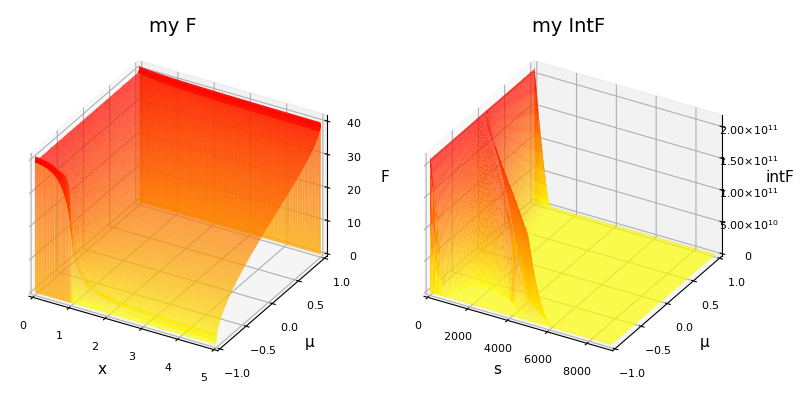

In [11]:
pyplot()
p1 = plot(my_xs, my_μs, my_Fs; xl="x", yl="μ", zl="F", 
    st = :surface, c=cgrad([:yellow, :red]), size=(600, 300), 
    title="my F", legend = false)
p2 = plot(my_Iss, my_Iμs, my_IFs; xl="s", yl="μ", zl="intF", 
    st = :surface, c=cgrad([:yellow, :red]), #size=(600, 300), 
    title="my IntF", legend = false)
p3 = plot(p1, p2, size=(800, 400))

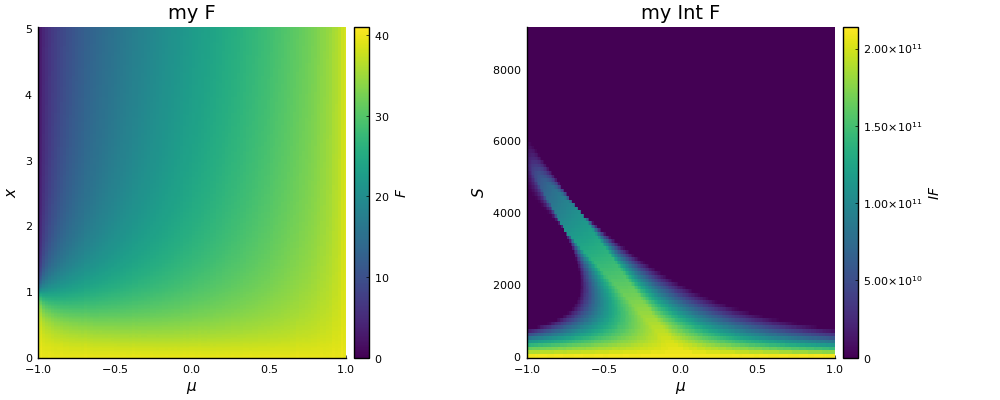

In [12]:
pyplot()

p1 = heatmap(unique(my_μs), unique(my_xs), matrix_Fs, xl=L"$\mu$", yl = L"$x$", colorbar_title=L"$F$", title = "my F")
p2 = heatmap(unique(my_Iμs), unique(my_Iss), matrix_IFs, xl=L"$\mu$", yl = L"$S$", colorbar_title=L"$IF$", title = "my Int F" )

plot(p1, p2, size = (1000, 400))

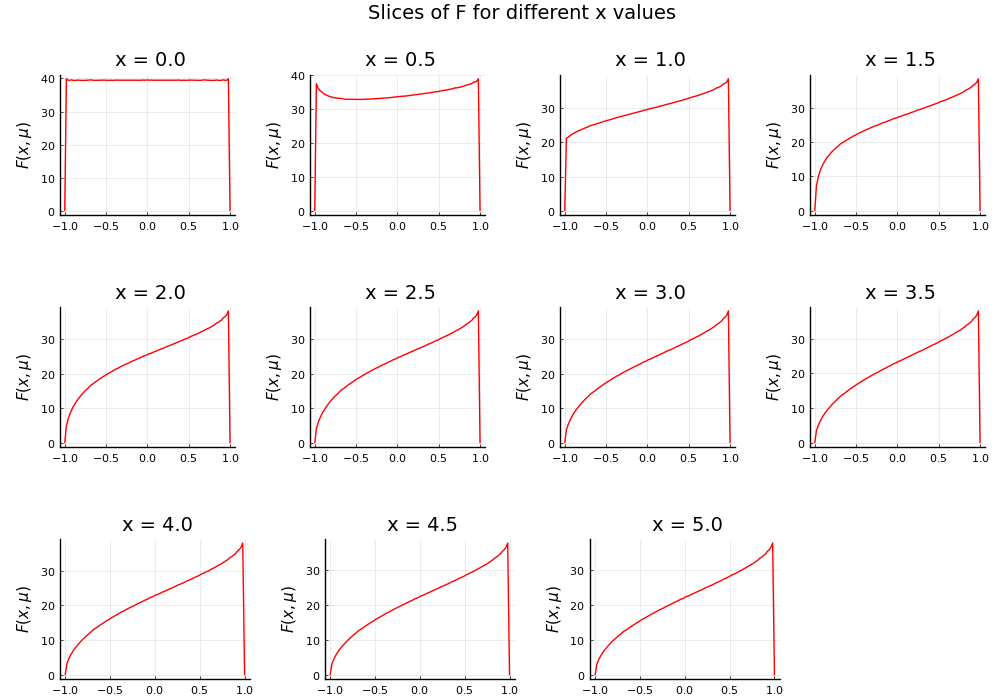

In [13]:
pyplot()

title = plot(title = "Slices of F for different x values", grid=false, 
    showaxis = false, bottom_margin = -25Plots.px, ticks=false)

θ_max =  π/2.0;
xs = [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0];
μs = range(-1.0, 1.0, length=100);

LIST_P = [plot() for i in 1:length(xs)]

for (i,x) in enumerate(xs)
    tit = "\n\n x = $x"
    xs_1 = μs
    ys_1 = [my_spline_F(x, μ) for μ in xs_1]

    LIST_P[i] = plot(xs_1, ys_1, 
        #xaxis=:log, yaxis=:log, 
        lc=:red, title=tit, legend=false,
        ylabel=L"F(x,\mu)", ls=:solid, 
        #xticks=10.0 .^ range(-3,0, step=1),
    )
end


l = @layout [ A{0.003h} ; a b c d ; e f g h ; i l j _]
ALL_PLOTS = plot(title, LIST_P..., layout=l,
    left_margins = 15Plots.px, right_margins = 15Plots.px, size=(1000,700))

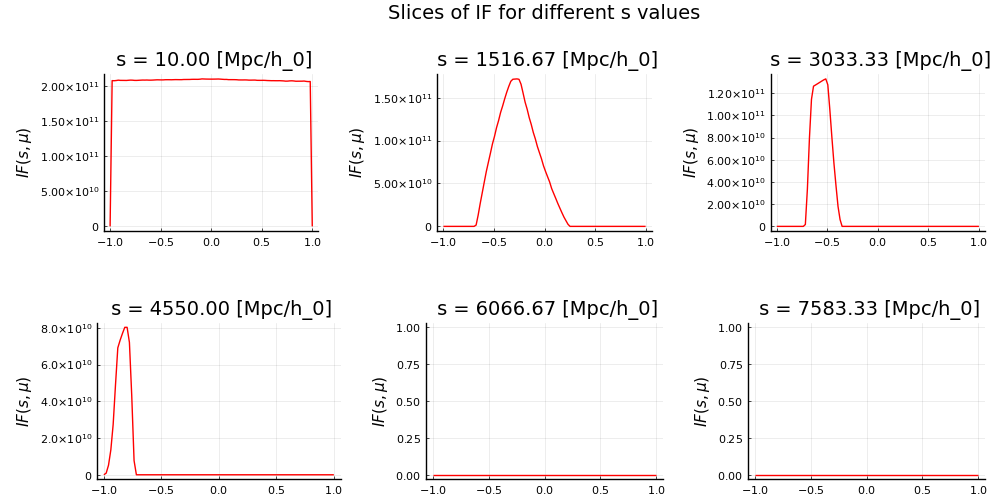

In [14]:
pyplot()

title = plot(title = "Slices of IF for different s values", grid=false, 
    showaxis = false, bottom_margin = -25Plots.px, ticks=false)

θ_max =  π/2.0;
ss = vcat([10.0], [i*max(my_Iss...)/6 for i in 1:5]);
μs = range(-1.0, 1.0, length=100);

LIST_P = [plot() for i in 1:length(ss)]
for (i,s) in enumerate(ss)
    tit = """\n\n s = $(@sprintf("%.2f",s)) [Mpc/h_0]"""
    xs_1 = μs
    ys_1 = [my_spline_IF(s, μ) for μ in xs_1]

    LIST_P[i] = plot(xs_1, ys_1, 
        #xaxis=:log, yaxis=:log, 
        lc=:red, title=tit, legend=false,
        ylabel=L"IF(s,\mu)", ls=:solid, 
        #xticks=10.0 .^ range(-3,0, step=1),
    )
end

l = @layout [ A{0.003h} ; a b c ; d e f ]
ALL_PLOTS = plot(title, LIST_P..., layout=l,
    left_margins = 15Plots.px, right_margins = 15Plots.px, size=(1000,500))

## Other stuff

In [15]:
IMPLEMENTED_GR_EFFECTS = [
     "auto_newton", "auto_doppler", "auto_lensing",
     "auto_localgp", "auto_integratedgp", 
     
     "newton_doppler", "doppler_newton",
     "newton_lensing", "lensing_newton",
     "newton_localgp", "localgp_newton",
     "newton_integratedgp", "integratedgp_newton",
     "lensing_doppler", "doppler_lensing",
     "doppler_localgp", "localgp_doppler",
     "doppler_integratedgp", "integratedgp_doppler",
     "lensing_localgp", "localgp_lensing",
     "lensing_integratedgp", "integratedgp_lensing",
     "localgp_integratedgp", "integratedgp_localgp",
];

func_ξs_names = [
    L::Int -> L"$\xi^{\delta \, \delta}_{L=%$L}(s)$", 
    L::Int -> L"$\xi^{v_{\parallel} \, v_{\parallel}}_{L=%$L}(s)$", 
    L::Int -> L"$\xi^{\kappa \, \kappa}_{L=%$L}(s)$", 
    L::Int -> L"$\xi^{\phi \, \phi}_{L=%$L}(s)$", 
    L::Int -> L"$\xi^{\int\phi \, \int\phi}_{L=%$L}(s)$", 
    
    L::Int -> L"$\xi^{\delta \, v_{\parallel}}_{L=%$L}(s)$",
    L::Int -> L"$\xi^{v_{\parallel} \, \delta}_{L=%$L}(s)$",
    
    L::Int -> L"$\xi^{\delta \, \kappa}_{L=%$L}(s)$",
    L::Int -> L"$\xi^{\kappa \, \delta}_{L=%$L}(s)$",
    
    L::Int -> L"$\xi^{\delta \, \phi}_{L=%$L}(s)$",
    L::Int -> L"$\xi^{\phi \, \delta}_{L=%$L}(s)$",
    
    L::Int -> L"$\xi^{\delta \, \int\phi}_{L=%$L}(s)$",
    L::Int -> L"$\xi^{\int\phi \, \delta}_{L=%$L}(s)$",
    
    L::Int -> L"$\xi^{\kappa \, v_{\parallel}}_{L=%$L}(s)$",
    L::Int -> L"$\xi^{v_{\parallel} \, \kappa}_{L=%$L}(s)$",
    
    L::Int -> L"$\xi^{v_{\parallel} \, \phi}_{L=%$L}(s)$",
    L::Int -> L"$\xi^{\phi \, v_{\parallel}}_{L=%$L}(s)$",
    
    L::Int -> L"$\xi^{v_{\parallel} \, \int\phi}_{L=%$L}(s)$",
    L::Int -> L"$\xi^{\int\phi \, v_{\parallel}}_{L=%$L}(s)$",
    
    L::Int -> L"$\xi^{\kappa \, \phi}_{L=%$L}(s)$",
    L::Int -> L"$\xi^{\phi \, \kappa}_{L=%$L}(s)$",
    
    L::Int -> L"$\xi^{\kappa \, \int\phi}_{L=%$L}(s)$",
    L::Int -> L"$\xi^{\int\phi \, \kappa}_{L=%$L}(s)$",
    
    L::Int -> L"$\xi^{\phi \, \int\phi}_{L=%$L}(s)$",
    L::Int -> L"$\xi^{\int\phi \, \phi}_{L=%$L}(s)$",
];


INDEX_GR_EFFECT = Dict([name => i for (i, name) in 
            enumerate(IMPLEMENTED_GR_EFFECTS)]...);
GR_EFFECT_INDEXED = Dict([i => name for (i, name) in 
            enumerate(IMPLEMENTED_GR_EFFECTS)]...);

## Monopoles L=0 computation

In [16]:
GaPSE.print_map_sum_ξ_GNC_multipole(
    cosmo, DIR * "GNC_sb0_fevo0_L0_noF_noobsvel_quad.txt", 
    10 .^ range(0, log10(2*cosmo.s_max), length = 300);
    L = 0, use_windows = false, alg = :quad, obs = :noobsvel,
    N_lob = 1000, N_trap = 5, atol_quad = 0.0, rtol_quad = 1e-2,
    N_χs = 100, N_χs_2 = 60);

auto_doppler, L=0: 100%|████████████████████████████████| Time: 0:00:00
auto_lensing, L=0: 100%|████████████████████████████████| Time: 0:03:37
auto_integratedgp, L=0: 100%|███████████████████████████| Time: 0:00:06
newton_lensing, L=0: 100%|██████████████████████████████| Time: 0:00:14
lensing_newton, L=0: 100%|██████████████████████████████| Time: 0:00:10
newton_integratedgp, L=0: 100%|█████████████████████████| Time: 0:00:02
integratedgp_newton, L=0: 100%|█████████████████████████| Time: 0:00:02
lensing_doppler, L=0: 100%|█████████████████████████████| Time: 0:00:02
doppler_lensing, L=0: 100%|█████████████████████████████| Time: 0:00:02
doppler_integratedgp, L=0: 100%|████████████████████████| Time: 0:00:01
integratedgp_doppler, L=0: 100%|████████████████████████| Time: 0:00:01
lensing_localgp, L=0: 100%|█████████████████████████████| Time: 0:00:02
localgp_lensing, L=0: 100%|█████████████████████████████| Time: 0:00:02
lensing_integratedgp, L=0: 100%|████████████████████████| Time: 


time needed for map_sum_ξ_GNC_multipole L=0[in s] = 311.10929 



In [17]:
GaPSE.print_map_sum_ξ_GNC_multipole(
    cosmo, DIR * "GNC_sb0_fevo0_L0_withF_noobsvel_quad.txt", 
    10 .^ range(0, log10(2*cosmo.s_max), length = 300);
    L = 0, use_windows = true, alg = :quad, obs = :noobsvel,
    N_lob = 1000, N_trap = 5, atol_quad = 0.0, rtol_quad = 1e-2,
    N_χs = 100, N_χs_2 = 60);

auto_newton, L=0: 100%|█████████████████████████████████| Time: 0:00:02
auto_doppler, L=0: 100%|████████████████████████████████| Time: 0:00:01
auto_lensing, L=0: 100%|████████████████████████████████| Time: 0:02:09
auto_localgp, L=0: 100%|████████████████████████████████| Time: 0:00:01
auto_integratedgp, L=0: 100%|███████████████████████████| Time: 0:00:14
newton_doppler, L=0: 100%|██████████████████████████████| Time: 0:00:02
doppler_newton, L=0: 100%|██████████████████████████████| Time: 0:00:01
newton_lensing, L=0: 100%|██████████████████████████████| Time: 0:00:11
lensing_newton, L=0: 100%|██████████████████████████████| Time: 0:00:11
newton_localgp, L=0: 100%|██████████████████████████████| Time: 0:00:01
localgp_newton, L=0: 100%|██████████████████████████████| Time: 0:00:01
newton_integratedgp, L=0: 100%|█████████████████████████| Time: 0:00:03
integratedgp_newton, L=0: 100%|█████████████████████████| Time: 0:00:03
lensing_doppler, L=0: 100%|█████████████████████████████| Time: 


time needed for map_sum_ξ_GNC_multipole L=0[in s] = 252.74415 



In [18]:
#=
GaPSE.print_map_sum_ξ_GNC_multipole(
    cosmo, DIR * "GNC_sb0_fevo0_L0_noF_noobsvel_lob.txt", 
    10 .^ range(0, log10(2*cosmo.s_max), length = 300);
    L = 0, use_windows = false, alg = :lobatto, obs = :noobsvel,
    N_lob = 1000, N_trap = 100, atol_quad = 0.0, rtol_quad = 1e-2,
    N_χs = 100, N_χs_2 = 50);
=#

In [19]:
#=
GaPSE.print_map_sum_ξ_GNC_multipole(
    cosmo, DIR * "GNC_sb0_fevo0_L0_withF_noobsvel_lob.txt", 
    10 .^ range(0, log10(2*cosmo.s_max), length = 300);
    L = 0, use_windows = true, alg = :lobatto, obs = :noobsvel,
    N_lob = 300, N_trap = 100, atol_quad = 0.0, rtol_quad = 1e-2,
    N_χs = 100, N_χs_2 = 30);
=#

## Multipoles L=1 computation

In [43]:
#=
GaPSE.print_map_sum_ξ_GNC_multipole(
    cosmo, DIR * "GNC_sb0_fevo0_L1_noF_noobsvel_lob.txt", 
    10 .^ range(0, log10(2*cosmo.s_max), length = 300);
    L = 1, use_windows = false, alg = :lobatto, obs = :noobsvel,
    N_lob = 1000, N_trap = 5, atol_quad = 0.0, rtol_quad = 1e-2,
    N_χs = 100, N_χs_2 = 60);
=#

In [44]:
#=
GaPSE.print_map_sum_ξ_GNC_multipole(
    cosmo, DIR * "GNC_sb0_fevo0_L1_withF_noobsvel_lob.txt", 
    10 .^ range(0, log10(2*cosmo.s_max), length = 300);
    L = 1, use_windows = true, alg = :lobatto, obs = :noobsvel,
    N_lob = 300, N_trap = 5, atol_quad = 0.0, rtol_quad = 1e-2,
    N_χs = 100, N_χs_2 = 60);
=#

## Multipoles L=2 computation

In [45]:
#=
GaPSE.print_map_sum_ξ_GNC_multipole(
    cosmo, DIR * "GNC_sb0_fevo0_L2_noF_noobsvel_lob.txt", 
    10 .^ range(0, log10(2*cosmo.s_max), length = 300);
    L = 2, use_windows = false, alg = :lobatto, obs = :noobsvel,
    N_lob = 1000, N_trap = 5, atol_quad = 0.0, rtol_quad = 1e-2,
    N_χs = 100, N_χs_2 = 60);
=#

In [46]:
#=
GaPSE.print_map_sum_ξ_GNC_multipole(
    cosmo, DIR * "GNC_sb0_fevo0_L2_withF_noobsvel_lob.txt", 
    10 .^ range(0, log10(2*cosmo.s_max), length = 300);
    L = 2, use_windows = true, alg = :lobatto, obs = :noobsvel,
    N_lob = 300, N_trap = 5, atol_quad = 0.0, rtol_quad = 1e-2,
    N_χs = 100, N_χs_2 = 60);
=#

## Multipoles L=3 computation

In [47]:
#=
GaPSE.print_map_sum_ξ_GNC_multipole(
    cosmo, DIR * "GNC_sb0_fevo0_L3_noF_noobsvel_lob.txt", 
    10 .^ range(0, log10(2*cosmo.s_max), length = 300);
    L = 3, use_windows = false, alg = :lobatto, obs = :noobsvel,
    N_lob = 1000, N_trap = 5, atol_quad = 0.0, rtol_quad = 1e-2,
    N_χs = 100, N_χs_2 = 60);
=#

In [48]:
#=
GaPSE.print_map_sum_ξ_GNC_multipole(
    cosmo, DIR * "GNC_sb0_fevo0_L3_withF_noobsvel_lob.txt", 
    10 .^ range(0, log10(2*cosmo.s_max), length = 300);
    L = 3, use_windows = true, alg = :lobatto, obs = :noobsvel,
    N_lob = 300, N_trap = 5, atol_quad = 0.0, rtol_quad = 1e-2,
    N_χs = 100, N_χs_2 = 60);
=#

## Multipoles L=4 computation

In [49]:
#=
GaPSE.print_map_sum_ξ_GNC_multipole(
    cosmo, DIR * "GNC_sb0_fevo0_L4_noF_noobsvel_lob.txt", 
    10 .^ range(0, log10(2*cosmo.s_max), length = 300);
    L = 4, use_windows = false, alg = :lobatto, obs = :noobsvel,
    N_lob = 1000, N_trap = 5, atol_quad = 0.0, rtol_quad = 1e-2,
    N_χs = 100, N_χs_2 = 60);
=#

In [50]:
#=
GaPSE.print_map_sum_ξ_GNC_multipole(
    cosmo, DIR * "GNC_sb0_fevo0_L4_withF_noobsvel_lob.txt", 
    10 .^ range(0, log10(2*cosmo.s_max), length = 300);
    L = 4, use_windows = true, alg = :lobatto, obs = :noobsvel,
    N_lob = 300, N_trap = 100, atol_quad = 0.0, rtol_quad = 1e-2,
    N_χs = 100, N_χs_2 = 60);
=#

## Reading the TPCFs files

In [57]:
ss_L0_noF_noobsvel_quad, res_sums_L0_noF_noobsvel_quad, res_xis_L0_noF_noobsvel_quad =
    GaPSE.readxyall(DIR * "GNC_sb0_fevo0_L0_noF_noobsvel_quad.txt", comments=true);
ss_L0_withF_noobsvel_quad, res_sums_L0_withF_noobsvel_quad, res_xis_L0_withF_noobsvel_quad =
    GaPSE.readxyall(DIR * "GNC_sb0_fevo0_L0_withF_noobsvel_quad.txt", comments=true);

In [51]:
#=
ss_L0_noF_noobsvel, res_sums_L0_noF_noobsvel, res_xis_L0_noF_noobsvel =
    GaPSE.readxyall(DIR * "GNC_sb0_fevo0_L0_noF_noobsvel_lob.txt", comments=true);
ss_L0_withF_noobsvel, res_sums_L0_withF_noobsvel, res_xis_L0_withF_noobsvel =
    GaPSE.readxyall(DIR * "GNC_sb0_fevo0_L0_withF_noobsvel_lob.txt", comments=true);
=#

In [52]:
#=
ss_L1_noF_noobsvel, res_sums_L1_noF_noobsvel, res_xis_L1_noF_noobsvel =
    GaPSE.readxyall(DIR * "GNC_sb0_fevo0_L1_noF_noobsvel_lob.txt", comments=true);
ss_L1_withF_noobsvel, res_sums_L1_withF_noobsvel, res_xis_L1_withF_noobsvel =
    GaPSE.readxyall(DIR * "GNC_sb0_fevo0_L1_withF_noobsvel_lob.txt", comments=true);
=#

In [53]:
#=
ss_L2_noF_noobsvel, res_sums_L2_noF_noobsvel, res_xis_L2_noF_noobsvel =
    GaPSE.readxyall(DIR * "GNC_sb0_fevo0_L2_noF_noobsvel_lob.txt", comments=true);
ss_L2_withF_noobsvel, res_sums_L2_withF_noobsvel, res_xis_L2_withF_noobsvel =
    GaPSE.readxyall(DIR * "GNC_sb0_fevo0_L2_withF_noobsvel_lob.txt", comments=true);
=#

In [54]:
#=
ss_L3_noF_noobsvel, res_sums_L3_noF_noobsvel, res_xis_L3_noF_noobsvel =
    GaPSE.readxyall(DIR * "GNC_sb0_fevo0_L3_noF_noobsvel_lob.txt", comments=true);
ss_L3_withF_noobsvel, res_sums_L3_withF_noobsvel, res_xis_L3_withF_noobsvel =
    GaPSE.readxyall(DIR * "GNC_sb0_fevo0_L3_withF_noobsvel_lob.txt", comments=true);
=#

In [55]:
#=
ss_L4_noF_noobsvel, res_sums_L4_noF_noobsvel, res_xis_L4_noF_noobsvel =
    GaPSE.readxyall(DIR * "GNC_sb0_fevo0_L4_noF_noobsvel_lob.txt", comments=true);
ss_L4_withF_noobsvel, res_sums_L4_withF_noobsvel, res_xis_L4_withF_noobsvel =
    GaPSE.readxyall(DIR * "GNC_sb0_fevo0_L4_withF_noobsvel_lob.txt", comments=true);
=#

## Check Plots

In [36]:
pyplot()
LIST_P = [plot() for i in 1:length(IMPLEMENTED_GR_EFFECTS)]

title = plot(title = "CFs for the GNC, without F, L=0, quad-lobatto, without obs-vel terms, for 1.0 < z < 1.5, with theta=pi/2", grid=false, 
    showaxis = false, bottom_margin = -30Plots.px, ticks=false, titlefontsize=20)

#=

legend_pos=[
    :bottomleft, :bottomleft, :bottomleft, :bottomleft, :bottomleft, 
    :bottomleft, :bottomleft, :bottomleft, :bottomleft, :bottomleft, 
    :bottomleft, :bottomleft, :bottomleft, :bottomleft,
    :bottomleft, :bottomleft, :bottomleft, :bottomleft,
     :bottomleft, :bottomleft, :bottomleft, :bottomleft,
    :bottomleft, :bottomleft, :bottomleft, :bottomleft,
    :bottomleft, :bottomleft, :bottomleft, :bottomleft,
]
=#

for (i,effect) in enumerate(IMPLEMENTED_GR_EFFECTS)
    tit = effect
    xs_1 = ss_L0_noF_noobsvel_quad
    ys_1 = res_xis_L0_noF_noobsvel_quad[i]
    xs_2 = ss_L0_noF_noobsvel
    ys_2 = res_xis_L0_noF_noobsvel[i]

    spline = Spline1D(xs_2, ys_2)

    S_VLIM = cosmo.s_eff
    S_VLIM_F = @sprintf("%.2f", S_VLIM)

    p1 = plot(
        #[xs_1, xs_2], [ys_1 .* xs_1 .^2, ys_2 .* xs_2 .^2], 
        #[xs_1, xs_2], [abs.(ys_1), abs.(ys_2)], 
        [xs_1[ys_1 .≠ 0], xs_2[ys_2 .≠ 0]], [abs.(ys_1)[ys_1 .≠ 0], abs.(ys_2)[ys_2 .≠ 0]], 
        lc=[:red :blue], ls=[:dash :dot], lw = [2 2],
        label=["quad" "lob"], title="\n"*tit,
        axis =:log,
        xticks = (
            vcat([a*10.0^b for b in 0:2 for a in 1:9], [a*10.0^3 for a in 1:5]), 
            vcat([a==1 ? L"10^{%$b}" : nothing for b in 0:2 for a in 1:9], L"10^{3}",[nothing for a in 2:5 ])
        ),
        grid=true,
        ylabel=func_ξs_names[i](0),
        #bottom_margin = -100Plots.px,
        legend=:bottomleft #legend_pos[i]
    )
    #[vline!(p1, [a*10.0^b], lc=:grey, lw=0.4, ls=:solid, label=false) for b in 0:3 for a in [1.0 5.0]]
    vline!(p1, [S_VLIM], label = false, #label="$S_VLIM_F Mpc/h_0", 
        lc=:black, lw=0.5, ls=:dash)

    p2 = plot(xs_1, spline.(xs_1) ./ ys_1, label="Ratio", 
        lc=:green, xaxis=:log,
        ylim=(0.95,1.05), 
        legend=:false, ylabel="ratio", 
        xticks = (
            vcat([a*10.0^b for b in 0:2 for a in 1:9], [a*10.0^3 for a in 1:5]), 
            vcat([a==1 ? L"10^{%$b}" : nothing for b in 0:2 for a in 1:9], L"10^{3}",[nothing for a in 2:5 ])
        ),
        xlabel=L"$s \quad [h_0^{-1}\,\mathrm{Mpc}]$")
    #[vline!(p2, [a*10.0^b], lc=:grey, lw=0.4, ls=:solid, label=false) for b in 0:3 for a in [1.0 5.0]]
    vline!(p2, [S_VLIM], label = false, #label="$S_VLIM_F Mpc/h_0", 
        lc=:black, lw=0.5, ls=:dash)

    LIST_P[i] = plot(p1, p2, size=(20, 40),
        layout= @layout [ x ; z ])
end

#l = @layout [a b ; c d ; e f ; g h ; i l ; m n ; o p ; q r ]
l = @layout [
    A{0.05h} 
    a  b  c
    d e _
    A B C D
    E F G H
    I L M N
    O P Q R
    S T U V
]

ll = @layout [ 
    A{0.01h}
    grid(5,5) 
]
ALL_PLOTS = plot(title, LIST_P..., layout = ll,
    #left_margins = 15Plots.px, right_margins = 15Plots.px, 
    size=(2000,3000))

#savefig(ALL_PLOTS, DIR * "GNC_sb0_fevo0_L0_noF_quad-lob_noobsvel.pdf")
#display(P)

LoadError: UndefVarError: ss_L0_noF_noobsvel not defined

In [ ]:
pyplot()
LIST_P = [plot() for i in 1:length(IMPLEMENTED_GR_EFFECTS)]

title = plot(title = "CFs for the GNC, with F, L=0, quad-lobatto, without obs-vel terms, for 1.0 < z < 1.5, with theta=pi/2", grid=false, 
    showaxis = false, bottom_margin = -30Plots.px, ticks=false, titlefontsize=20)

#=
legend_pos=[
    :bottomleft, :bottomleft, :bottomleft, :bottomleft, :bottomleft, 
    :bottomleft, :bottomleft, :bottomleft, :bottomleft, :bottomleft, 
    :bottomleft, :bottomleft, :bottomleft, :bottomleft,
    :bottomleft, :bottomleft, :bottomleft, :bottomleft,
     :bottomleft, :bottomleft, :bottomleft, :bottomleft,
    :bottomleft, :bottomleft, :bottomleft, :bottomleft,
    :bottomleft, :bottomleft, :bottomleft, :bottomleft,
]
=#

for (i,effect) in enumerate(IMPLEMENTED_GR_EFFECTS)
    tit = effect
    xs_1 = ss_L0_withF_noobsvel_quad
    ys_1 = res_xis_L0_withF_noobsvel_quad[i]
    xs_2 = ss_L0_withF_noobsvel
    ys_2 = res_xis_L0_withF_noobsvel[i]

    spline = Spline1D(xs_2, ys_2)

    S_VLIM = cosmo.s_eff
    S_VLIM_F = @sprintf("%.2f", S_VLIM)

    p1 = plot(
        #[xs_1, xs_2], [ys_1 .* xs_1 .^2, ys_2 .* xs_2 .^2], 
        #[xs_1, xs_2], [abs.(ys_1), abs.(ys_2)], 
        [xs_1[ys_1 .≠ 0], xs_2[ys_2 .≠ 0]], [abs.(ys_1)[ys_1 .≠ 0], abs.(ys_2)[ys_2 .≠ 0]], 
        lc=[:red :blue], ls=[:dash :dot], lw = [2 2],
        label=["quad" "lob"], title="\n"*tit,
        axis =:log,
        xticks = (
            vcat([a*10.0^b for b in 0:2 for a in 1:9], [a*10.0^3 for a in 1:5]), 
            vcat([a==1 ? L"10^{%$b}" : nothing for b in 0:2 for a in 1:9], L"10^{3}",[nothing for a in 2:5 ])
        ),
        grid=true,
        ylabel=func_ξs_names[i](0),
        #bottom_margin = -100Plots.px,
        legend=:bottomleft #legend_pos[i]
    )
    #[vline!(p1, [a*10.0^b], lc=:grey, lw=0.4, ls=:solid, label=false) for b in 0:3 for a in [1.0 5.0]]
    vline!(p1, [S_VLIM], label = false, #label="$S_VLIM_F Mpc/h_0", 
        lc=:black, lw=0.5, ls=:dash)

    p2 = plot(xs_1, spline.(xs_1) ./ ys_1, label="Ratio", 
        lc=:green, xaxis=:log,
        ylim=(0.95,1.05), 
        legend=:false, ylabel="ratio", 
        xticks = (
            vcat([a*10.0^b for b in 0:2 for a in 1:9], [a*10.0^3 for a in 1:5]), 
            vcat([a==1 ? L"10^{%$b}" : nothing for b in 0:2 for a in 1:9], L"10^{3}",[nothing for a in 2:5 ])
        ),
        xlabel=L"$s \quad [h_0^{-1}\,\mathrm{Mpc}]$")
    #[vline!(p2, [a*10.0^b], lc=:grey, lw=0.4, ls=:solid, label=false) for b in 0:3 for a in [1.0 5.0]]
    vline!(p2, [S_VLIM], label = false, #label="$S_VLIM_F Mpc/h_0", 
        lc=:black, lw=0.5, ls=:dash)

    LIST_P[i] = plot(p1, p2, size=(20, 40),
        layout= @layout [ x ; z ])
end

#l = @layout [a b ; c d ; e f ; g h ; i l ; m n ; o p ; q r ]
l = @layout [
    A{0.05h} 
    a  b  c
    d e _
    A B C D
    E F G H
    I L M N
    O P Q R
    S T U V
]

ll = @layout [ 
    A{0.01h}
    grid(5,5) 
]
ALL_PLOTS = plot(title, LIST_P..., layout = ll,
    #left_margins = 15Plots.px, right_margins = 15Plots.px, 
    size=(2000,3000))

#savefig(ALL_PLOTS, DIR * "GNC_sb0_fevo0_L0_withF_quad-lob_noobsvel.pdf")
#display(P)

LoadError: UndefVarError: ss_L0_withF_noobsvel not defined

## Plots

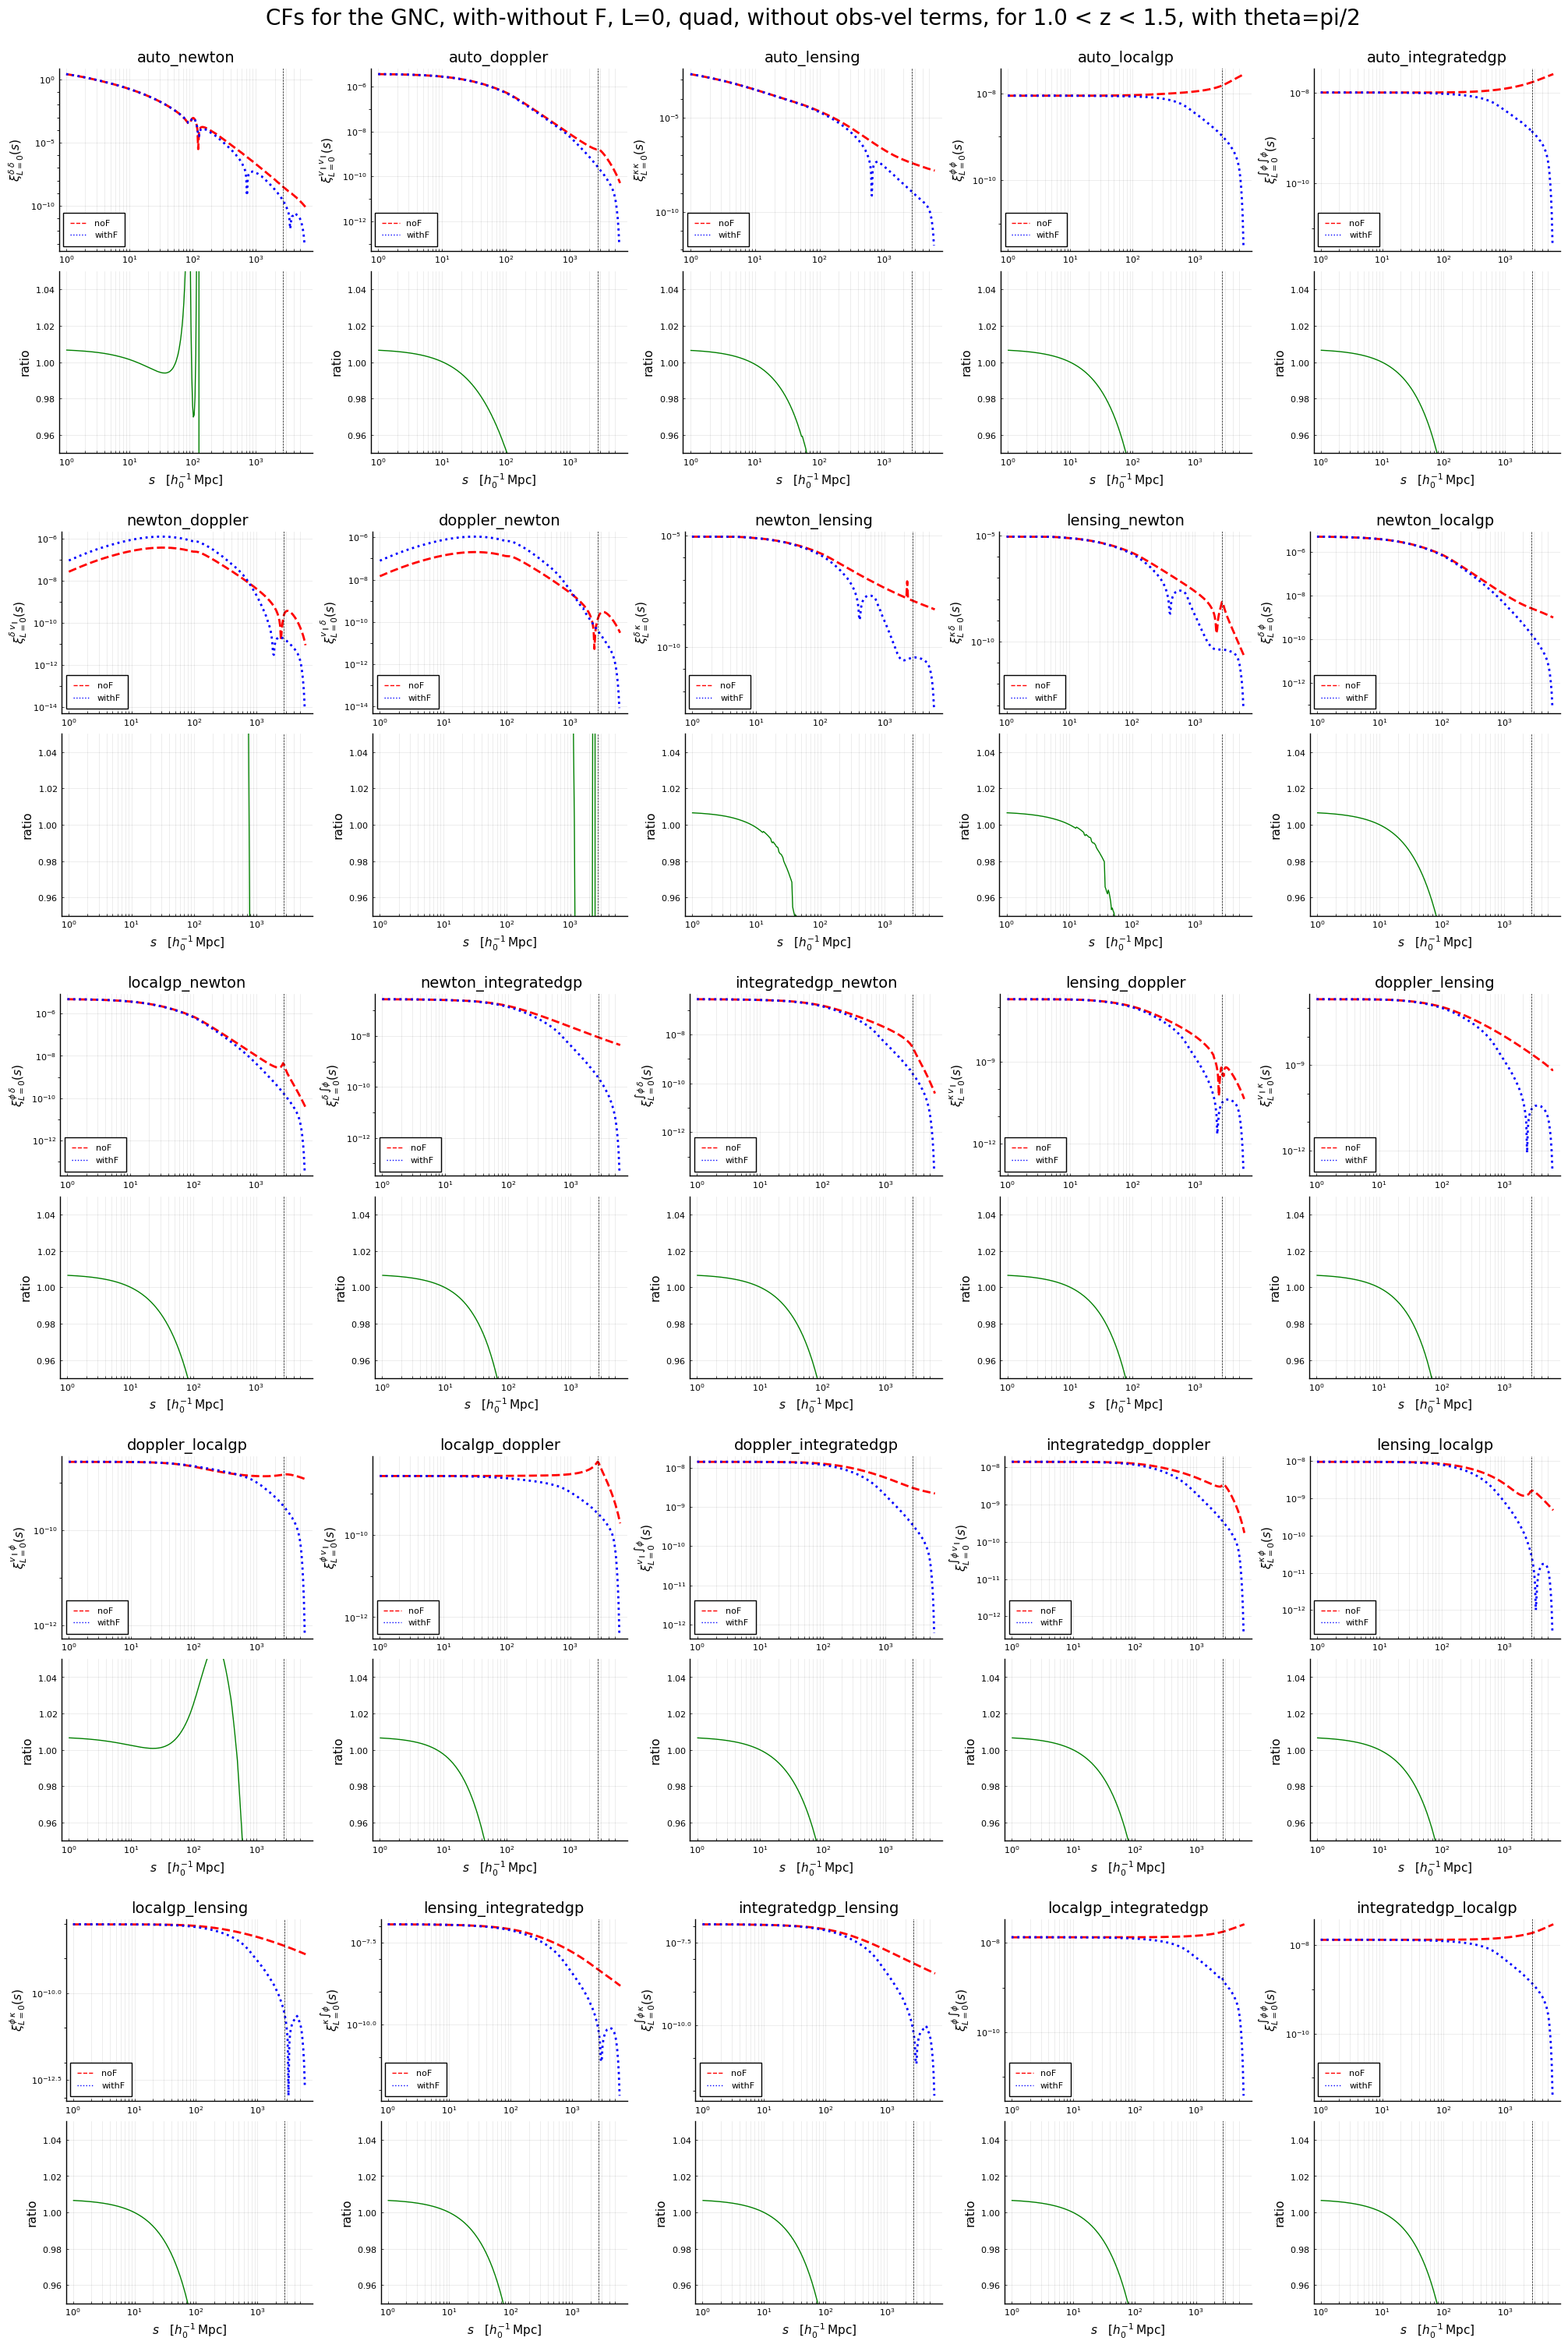

"/Users/di75tom/AAA_TESI_MAGISTRALE/GaPSE/ipynbs/GNC_sb0_fevo0/GNC_sb0_fevo0_L0_noF-withF_noobsvel.pdf"

In [63]:
pyplot()
LIST_P = [plot() for i in 1:length(IMPLEMENTED_GR_EFFECTS)]

title = plot(title = "CFs for the GNC, with-without F, L=0, quad, without obs-vel terms, for 1.0 < z < 1.5, with theta=pi/2", grid=false, 
    showaxis = false, bottom_margin = -30Plots.px, ticks=false, titlefontsize=20)

#=
legend_pos=[
    :bottomleft, :bottomleft, :bottomleft, :bottomleft, :bottomleft, 
    :bottomleft, :bottomleft, :bottomleft, :bottomleft, :bottomleft, 
    :bottomleft, :bottomleft, :bottomleft, :bottomleft,
    :bottomleft, :bottomleft, :bottomleft, :bottomleft,
     :bottomleft, :bottomleft, :bottomleft, :bottomleft,
    :bottomleft, :bottomleft, :bottomleft, :bottomleft,
    :bottomleft, :bottomleft, :bottomleft, :bottomleft,
]
=#

for (i,effect) in enumerate(IMPLEMENTED_GR_EFFECTS)
    tit = effect
    xs_1 = ss_L0_noF_noobsvel_quad
    ys_1 = res_xis_L0_noF_noobsvel_quad[i]
    xs_2 = ss_L0_withF_noobsvel_quad
    ys_2 = res_xis_L0_withF_noobsvel_quad[i]

    spline = Spline1D(xs_2, ys_2)

    S_VLIM = cosmo.s_eff
    S_VLIM_F = @sprintf("%.2f", S_VLIM)

    p1 = plot(
        #[xs_1, xs_2], [ys_1 .* xs_1 .^2, ys_2 .* xs_2 .^2], 
        #[xs_1, xs_2], [abs.(ys_1), abs.(ys_2)], 
        [xs_1[ys_1 .≠ 0], xs_2[ys_2 .≠ 0]], [abs.(ys_1)[ys_1 .≠ 0], abs.(ys_2)[ys_2 .≠ 0]], 
        lc=[:red :blue], ls=[:dash :dot], lw = [2 2],
        label=["noF" "withF"], title="\n"*tit,
        axis =:log,
        xticks = (
            vcat([a*10.0^b for b in 0:2 for a in 1:9], [a*10.0^3 for a in 1:5]), 
            vcat([a==1 ? L"10^{%$b}" : nothing for b in 0:2 for a in 1:9], L"10^{3}",[nothing for a in 2:5 ])
        ),
        grid=true,
        ylabel=func_ξs_names[i](0),
        #bottom_margin = -100Plots.px,
        legend=:bottomleft #legend_pos[i]
    )
    #[vline!(p1, [a*10.0^b], lc=:grey, lw=0.4, ls=:solid, label=false) for b in 0:3 for a in [1.0 5.0]]
    vline!(p1, [S_VLIM], label = false, #label="$S_VLIM_F Mpc/h_0", 
        lc=:black, lw=0.5, ls=:dash)

    p2 = plot(xs_1, spline.(xs_1) ./ ys_1, label="Ratio", 
        lc=:green, xaxis=:log,
        ylim=(0.95,1.05), 
        legend=:false, ylabel="ratio", 
        xticks = (
            vcat([a*10.0^b for b in 0:2 for a in 1:9], [a*10.0^3 for a in 1:5]), 
            vcat([a==1 ? L"10^{%$b}" : nothing for b in 0:2 for a in 1:9], L"10^{3}",[nothing for a in 2:5 ])
        ),
        xlabel=L"$s \quad [h_0^{-1}\,\mathrm{Mpc}]$")
    #[vline!(p2, [a*10.0^b], lc=:grey, lw=0.4, ls=:solid, label=false) for b in 0:3 for a in [1.0 5.0]]
    vline!(p2, [S_VLIM], label = false, #label="$S_VLIM_F Mpc/h_0", 
        lc=:black, lw=0.5, ls=:dash)

    LIST_P[i] = plot(p1, p2, size=(20, 40),
        layout= @layout [ x ; z ])
end

#l = @layout [a b ; c d ; e f ; g h ; i l ; m n ; o p ; q r ]
l = @layout [
    A{0.05h} 
    a  b  c
    d e _
    A B C D
    E F G H
    I L M N
    O P Q R
    S T U V
]

ll = @layout [ 
    A{0.01h}
    grid(5,5) 
]
ALL_PLOTS = plot(title, LIST_P..., layout = ll,
    #left_margins = 15Plots.px, right_margins = 15Plots.px, 
    size=(2000,3000))

savefig(ALL_PLOTS, DIR * "GNC_sb0_fevo0_L0_noF-withF_noobsvel.pdf")
#display(P)

In [39]:
pyplot()
LIST_P = [plot() for i in 1:length(IMPLEMENTED_GR_EFFECTS)]

title = plot(title = "CFs for the GNC, with-without F, L=1, lob, without obs-vel terms, for 1.0 < z < 1.5, with theta=pi/2", grid=false, 
    showaxis = false, bottom_margin = -30Plots.px, ticks=false, titlefontsize=20)

#=
legend_pos=[
    :bottomleft, :bottomleft, :bottomleft, :bottomleft, :bottomleft, 
    :bottomleft, :bottomleft, :bottomleft, :bottomleft, :bottomleft, 
    :bottomleft, :bottomleft, :bottomleft, :bottomleft,
    :bottomleft, :bottomleft, :bottomleft, :bottomleft,
     :bottomleft, :bottomleft, :bottomleft, :bottomleft,
    :bottomleft, :bottomleft, :bottomleft, :bottomleft,
    :bottomleft, :bottomleft, :bottomleft, :bottomleft,
]
=#

for (i,effect) in enumerate(IMPLEMENTED_GR_EFFECTS)
    tit = effect
    xs_1 = ss_L1_noF_noobsvel
    ys_1 = res_xis_L1_noF_noobsvel[i]
    xs_2 = ss_L1_withF_noobsvel
    ys_2 = res_xis_L1_withF_noobsvel[i]

    spline = Spline1D(xs_2, ys_2)

    S_VLIM = cosmo.s_eff
    S_VLIM_F = @sprintf("%.2f", S_VLIM)

    p1 = plot(
        #[xs_1, xs_2], [ys_1 .* xs_1 .^2, ys_2 .* xs_2 .^2], 
        #[xs_1, xs_2], [abs.(ys_1), abs.(ys_2)], 
        [xs_1[ys_1 .≠ 0], xs_2[ys_2 .≠ 0]], [abs.(ys_1)[ys_1 .≠ 0], abs.(ys_2)[ys_2 .≠ 0]], 
        lc=[:red :blue], ls=[:dash :dot], lw = [2 2],
        label=["noF" "withF"], title="\n"*tit,
        axis =:log,
        xticks = (
            vcat([a*10.0^b for b in 0:2 for a in 1:9], [a*10.0^3 for a in 1:5]), 
            vcat([a==1 ? L"10^{%$b}" : nothing for b in 0:2 for a in 1:9], L"10^{3}",[nothing for a in 2:5 ])
        ),
        grid=true,
        ylabel=func_ξs_names[i](1),
        #bottom_margin = -100Plots.px,
        legend=:bottomleft #legend_pos[i]
    )
    #[vline!(p1, [a*10.0^b], lc=:grey, lw=0.4, ls=:solid, label=false) for b in 0:3 for a in [1.0 5.0]]
    vline!(p1, [S_VLIM], label = false, #label="$S_VLIM_F Mpc/h_0", 
        lc=:black, lw=0.5, ls=:dash)

    p2 = plot(xs_1, spline.(xs_1) ./ ys_1, label="Ratio", 
        lc=:green, xaxis=:log,
        ylim=(0.95,1.05), 
        legend=:false, ylabel="ratio", 
        xticks = (
            vcat([a*10.0^b for b in 0:2 for a in 1:9], [a*10.0^3 for a in 1:5]), 
            vcat([a==1 ? L"10^{%$b}" : nothing for b in 0:2 for a in 1:9], L"10^{3}",[nothing for a in 2:5 ])
        ),
        xlabel=L"$s \quad [h_0^{-1}\,\mathrm{Mpc}]$")
    #[vline!(p2, [a*10.0^b], lc=:grey, lw=0.4, ls=:solid, label=false) for b in 0:3 for a in [1.0 5.0]]
    vline!(p2, [S_VLIM], label = false, #label="$S_VLIM_F Mpc/h_0", 
        lc=:black, lw=0.5, ls=:dash)

    LIST_P[i] = plot(p1, p2, size=(20, 40),
        layout= @layout [ x ; z ])
end

#l = @layout [a b ; c d ; e f ; g h ; i l ; m n ; o p ; q r ]
l = @layout [
    A{0.05h} 
    a  b  c
    d e _
    A B C D
    E F G H
    I L M N
    O P Q R
    S T U V
]

ll = @layout [ 
    A{0.01h}
    grid(5,5) 
]
ALL_PLOTS = plot(title, LIST_P..., layout = ll,
    #left_margins = 15Plots.px, right_margins = 15Plots.px, 
    size=(2000,3000))

savefig(ALL_PLOTS, DIR * "GNC_sb0_fevo0_L0_noF-withF_noobsvel.pdf")
#display(P)

LoadError: UndefVarError: ss_L1_noF_noobsvel not defined

In [40]:
pyplot()
LIST_P = [plot() for i in 1:length(IMPLEMENTED_GR_EFFECTS)]

title = plot(title = "CFs for the GNC, with-without F, L=2, lob, without obs-vel terms, for 1.0 < z < 1.5, with theta=pi/2", grid=false, 
    showaxis = false, bottom_margin = -30Plots.px, ticks=false, titlefontsize=20)

#=
legend_pos=[
    :bottomleft, :bottomleft, :bottomleft, :bottomleft, :bottomleft, 
    :bottomleft, :bottomleft, :bottomleft, :bottomleft, :bottomleft, 
    :bottomleft, :bottomleft, :bottomleft, :bottomleft,
    :bottomleft, :bottomleft, :bottomleft, :bottomleft,
     :bottomleft, :bottomleft, :bottomleft, :bottomleft,
    :bottomleft, :bottomleft, :bottomleft, :bottomleft,
    :bottomleft, :bottomleft, :bottomleft, :bottomleft,
]
=#

for (i,effect) in enumerate(IMPLEMENTED_GR_EFFECTS)
    tit = effect
    xs_1 = ss_L2_noF_noobsvel
    ys_1 = res_xis_L2_noF_noobsvel[i]
    xs_2 = ss_L2_withF_noobsvel
    ys_2 = res_xis_L2_withF_noobsvel[i]

    spline = Spline1D(xs_2, ys_2)

    S_VLIM = cosmo.s_eff
    S_VLIM_F = @sprintf("%.2f", S_VLIM)

    p1 = plot(
        #[xs_1, xs_2], [ys_1 .* xs_1 .^2, ys_2 .* xs_2 .^2], 
        #[xs_1, xs_2], [abs.(ys_1), abs.(ys_2)], 
        [xs_1[ys_1 .≠ 0], xs_2[ys_2 .≠ 0]], [abs.(ys_1)[ys_1 .≠ 0], abs.(ys_2)[ys_2 .≠ 0]], 
        lc=[:red :blue], ls=[:dash :dot], lw = [2 2],
        label=["noF" "withF"], title="\n"*tit,
        axis =:log,
        xticks = (
            vcat([a*10.0^b for b in 0:2 for a in 1:9], [a*10.0^3 for a in 1:5]), 
            vcat([a==1 ? L"10^{%$b}" : nothing for b in 0:2 for a in 1:9], L"10^{3}",[nothing for a in 2:5 ])
        ),
        grid=true,
        ylabel=func_ξs_names[i](2),
        #bottom_margin = -100Plots.px,
        legend=:bottomleft #legend_pos[i]
    )
    #[vline!(p1, [a*10.0^b], lc=:grey, lw=0.4, ls=:solid, label=false) for b in 0:3 for a in [1.0 5.0]]
    vline!(p1, [S_VLIM], label = false, #label="$S_VLIM_F Mpc/h_0", 
        lc=:black, lw=0.5, ls=:dash)

    p2 = plot(xs_1, spline.(xs_1) ./ ys_1, label="Ratio", 
        lc=:green, xaxis=:log,
        ylim=(0.95,1.05), 
        legend=:false, ylabel="ratio", 
        xticks = (
            vcat([a*10.0^b for b in 0:2 for a in 1:9], [a*10.0^3 for a in 1:5]), 
            vcat([a==1 ? L"10^{%$b}" : nothing for b in 0:2 for a in 1:9], L"10^{3}",[nothing for a in 2:5 ])
        ),
        xlabel=L"$s \quad [h_0^{-1}\,\mathrm{Mpc}]$")
    #[vline!(p2, [a*10.0^b], lc=:grey, lw=0.4, ls=:solid, label=false) for b in 0:3 for a in [1.0 5.0]]
    vline!(p2, [S_VLIM], label = false, #label="$S_VLIM_F Mpc/h_0", 
        lc=:black, lw=0.5, ls=:dash)

    LIST_P[i] = plot(p1, p2, size=(20, 40),
        layout= @layout [ x ; z ])
end

#l = @layout [a b ; c d ; e f ; g h ; i l ; m n ; o p ; q r ]
l = @layout [
    A{0.05h} 
    a  b  c
    d e _
    A B C D
    E F G H
    I L M N
    O P Q R
    S T U V
]

ll = @layout [ 
    A{0.01h}
    grid(5,5) 
]
ALL_PLOTS = plot(title, LIST_P..., layout = ll,
    #left_margins = 15Plots.px, right_margins = 15Plots.px, 
    size=(2000,3000))

savefig(ALL_PLOTS, DIR * "GNC_sb0_fevo0_L2_noF-withF_noobsvel.pdf")
#display(P)

LoadError: UndefVarError: ss_L2_noF_noobsvel not defined

In [41]:
pyplot()
LIST_P = [plot() for i in 1:length(IMPLEMENTED_GR_EFFECTS)]

title = plot(title = "CFs for the GNC, with-without F, L=3, lob, without obs-vel terms, for 1.0 < z < 1.5, with theta=pi/2", grid=false, 
    showaxis = false, bottom_margin = -30Plots.px, ticks=false, titlefontsize=20)

#=
legend_pos=[
    :bottomleft, :bottomleft, :bottomleft, :bottomleft, :bottomleft, 
    :bottomleft, :bottomleft, :bottomleft, :bottomleft, :bottomleft, 
    :bottomleft, :bottomleft, :bottomleft, :bottomleft,
    :bottomleft, :bottomleft, :bottomleft, :bottomleft,
     :bottomleft, :bottomleft, :bottomleft, :bottomleft,
    :bottomleft, :bottomleft, :bottomleft, :bottomleft,
    :bottomleft, :bottomleft, :bottomleft, :bottomleft,
]
=#

for (i,effect) in enumerate(IMPLEMENTED_GR_EFFECTS)
    tit = effect
    xs_1 = ss_L3_noF_noobsvel
    ys_1 = res_xis_L3_noF_noobsvel[i]
    xs_2 = ss_L3_withF_noobsvel
    ys_2 = res_xis_L3_withF_noobsvel[i]

    spline = Spline1D(xs_2, ys_2)

    S_VLIM = cosmo.s_eff
    S_VLIM_F = @sprintf("%.2f", S_VLIM)

    p1 = plot(
        #[xs_1, xs_2], [ys_1 .* xs_1 .^2, ys_2 .* xs_2 .^2], 
        #[xs_1, xs_2], [abs.(ys_1), abs.(ys_2)], 
        [xs_1[ys_1 .≠ 0], xs_2[ys_2 .≠ 0]], [abs.(ys_1)[ys_1 .≠ 0], abs.(ys_2)[ys_2 .≠ 0]], 
        lc=[:red :blue], ls=[:dash :dot], lw = [2 2],
        label=["noF" "withF"], title="\n"*tit,
        axis =:log,
        xticks = (
            vcat([a*10.0^b for b in 0:2 for a in 1:9], [a*10.0^3 for a in 1:5]), 
            vcat([a==1 ? L"10^{%$b}" : nothing for b in 0:2 for a in 1:9], L"10^{3}",[nothing for a in 2:5 ])
        ),
        grid=true,
        ylabel=func_ξs_names[i](3),
        #bottom_margin = -100Plots.px,
        legend=:bottomleft #legend_pos[i]
    )
    #[vline!(p1, [a*10.0^b], lc=:grey, lw=0.4, ls=:solid, label=false) for b in 0:3 for a in [1.0 5.0]]
    vline!(p1, [S_VLIM], label = false, #label="$S_VLIM_F Mpc/h_0", 
        lc=:black, lw=0.5, ls=:dash)

    p2 = plot(xs_1, spline.(xs_1) ./ ys_1, label="Ratio", 
        lc=:green, xaxis=:log,
        ylim=(0.95,1.05), 
        legend=:false, ylabel="ratio", 
        xticks = (
            vcat([a*10.0^b for b in 0:2 for a in 1:9], [a*10.0^3 for a in 1:5]), 
            vcat([a==1 ? L"10^{%$b}" : nothing for b in 0:2 for a in 1:9], L"10^{3}",[nothing for a in 2:5 ])
        ),
        xlabel=L"$s \quad [h_0^{-1}\,\mathrm{Mpc}]$")
    #[vline!(p2, [a*10.0^b], lc=:grey, lw=0.4, ls=:solid, label=false) for b in 0:3 for a in [1.0 5.0]]
    vline!(p2, [S_VLIM], label = false, #label="$S_VLIM_F Mpc/h_0", 
        lc=:black, lw=0.5, ls=:dash)

    LIST_P[i] = plot(p1, p2, size=(20, 40),
        layout= @layout [ x ; z ])
end

#l = @layout [a b ; c d ; e f ; g h ; i l ; m n ; o p ; q r ]
l = @layout [
    A{0.05h} 
    a  b  c
    d e _
    A B C D
    E F G H
    I L M N
    O P Q R
    S T U V
]

ll = @layout [ 
    A{0.01h}
    grid(5,5) 
]
ALL_PLOTS = plot(title, LIST_P..., layout = ll,
    #left_margins = 15Plots.px, right_margins = 15Plots.px, 
    size=(2000,3000))

savefig(ALL_PLOTS, DIR * "GNC_sb0_fevo0_L3_noF-withF_noobsvel.pdf")
#display(P)

LoadError: UndefVarError: ss_L3_noF_noobsvel not defined

In [42]:
pyplot()
LIST_P = [plot() for i in 1:length(IMPLEMENTED_GR_EFFECTS)]

title = plot(title = "CFs for the GNC, with-without F, L=4, lob, without obs-vel terms, for 1.0 < z < 1.5, with theta=pi/2", grid=false, 
    showaxis = false, bottom_margin = -30Plots.px, ticks=false, titlefontsize=20)

#=
legend_pos=[
    :bottomleft, :bottomleft, :bottomleft, :bottomleft, :bottomleft, 
    :bottomleft, :bottomleft, :bottomleft, :bottomleft, :bottomleft, 
    :bottomleft, :bottomleft, :bottomleft, :bottomleft,
    :bottomleft, :bottomleft, :bottomleft, :bottomleft,
     :bottomleft, :bottomleft, :bottomleft, :bottomleft,
    :bottomleft, :bottomleft, :bottomleft, :bottomleft,
    :bottomleft, :bottomleft, :bottomleft, :bottomleft,
]
=#

for (i,effect) in enumerate(IMPLEMENTED_GR_EFFECTS)
    tit = effect
    xs_1 = ss_L4_noF_noobsvel
    ys_1 = res_xis_L4_noF_noobsvel[i]
    xs_2 = ss_L4_withF_noobsvel
    ys_2 = res_xis_L4_withF_noobsvel[i]

    spline = Spline1D(xs_2, ys_2)

    S_VLIM = cosmo.s_eff
    S_VLIM_F = @sprintf("%.2f", S_VLIM)

    p1 = plot(
        #[xs_1, xs_2], [ys_1 .* xs_1 .^2, ys_2 .* xs_2 .^2], 
        #[xs_1, xs_2], [abs.(ys_1), abs.(ys_2)], 
        [xs_1[ys_1 .≠ 0], xs_2[ys_2 .≠ 0]], [abs.(ys_1)[ys_1 .≠ 0], abs.(ys_2)[ys_2 .≠ 0]], 
        lc=[:red :blue], ls=[:dash :dot], lw = [2 2],
        label=["noF" "withF"], title="\n"*tit,
        axis =:log,
        xticks = (
            vcat([a*10.0^b for b in 0:2 for a in 1:9], [a*10.0^3 for a in 1:5]), 
            vcat([a==1 ? L"10^{%$b}" : nothing for b in 0:2 for a in 1:9], L"10^{3}",[nothing for a in 2:5 ])
        ),
        grid=true,
        ylabel=func_ξs_names[i](4),
        #bottom_margin = -100Plots.px,
        legend=:bottomleft #legend_pos[i]
    )
    #[vline!(p1, [a*10.0^b], lc=:grey, lw=0.4, ls=:solid, label=false) for b in 0:3 for a in [1.0 5.0]]
    vline!(p1, [S_VLIM], label = false, #label="$S_VLIM_F Mpc/h_0", 
        lc=:black, lw=0.5, ls=:dash)

    p2 = plot(xs_1, spline.(xs_1) ./ ys_1, label="Ratio", 
        lc=:green, xaxis=:log,
        ylim=(0.95,1.05), 
        legend=:false, ylabel="ratio", 
        xticks = (
            vcat([a*10.0^b for b in 0:2 for a in 1:9], [a*10.0^3 for a in 1:5]), 
            vcat([a==1 ? L"10^{%$b}" : nothing for b in 0:2 for a in 1:9], L"10^{3}",[nothing for a in 2:5 ])
        ),
        xlabel=L"$s \quad [h_0^{-1}\,\mathrm{Mpc}]$")
    #[vline!(p2, [a*10.0^b], lc=:grey, lw=0.4, ls=:solid, label=false) for b in 0:3 for a in [1.0 5.0]]
    vline!(p2, [S_VLIM], label = false, #label="$S_VLIM_F Mpc/h_0", 
        lc=:black, lw=0.5, ls=:dash)

    LIST_P[i] = plot(p1, p2, size=(20, 40),
        layout= @layout [ x ; z ])
end

#l = @layout [a b ; c d ; e f ; g h ; i l ; m n ; o p ; q r ]
l = @layout [
    A{0.05h} 
    a  b  c
    d e _
    A B C D
    E F G H
    I L M N
    O P Q R
    S T U V
]

ll = @layout [ 
    A{0.01h}
    grid(5,5) 
]
ALL_PLOTS = plot(title, LIST_P..., layout = ll,
    #left_margins = 15Plots.px, right_margins = 15Plots.px, 
    size=(2000,3000))

savefig(ALL_PLOTS, DIR * "GNC_sb0_fevo0_L4_noF-withF_noobsvel.pdf")
#display(P)

LoadError: UndefVarError: ss_L4_noF_noobsvel not defined

## Other things